# Team 20 - Alternate Method: PCA + New Features
## 6m Data with Decision Tree and Random Forest
**Bureau of Transportation Statistics:**   
https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236   
https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations

In [0]:
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext
from pyspark.ml.feature import PCA, RFormula
from pyspark.ml.linalg import Vectors
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.util import MLUtils
sqlContext = SQLContext(sc)

### Data Processing

**Helper Functions**

In [0]:
## helper function to count number of missing values in each column
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([f.count(f.when(f.isnull(c) | f.isnan(c), c)).alias(c) for c in spark_df.columns]).toPandas()
    if len(df) == 0:
        print("There are no any missing values!")
        return None
    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)
    return df
  
## helper funciton to run for the weather variables that need to be split into separate columns
def column_split(variables, data):
  for v in variables:
    split = f.split(data[v],',')
    for i in range(len(data.select(split).first()[0])):
      data = data.withColumn(v+'_'+str(i), split.getItem(i).cast(IntegerType()))
  data = data.drop(*variables)
  return data


**Import Data**

In [0]:
# airlines
# airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/201*.parquet")

airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/")

# weather
weather = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather201*a.parquet")

# stations
stations = spark.read.option("header", "true").csv("dbfs:/mnt/mids-w261/DEMO8/gsod/stations.csv.gz")

# codes to join weather station and airports
codes = spark.read.format("csv").load("dbfs:/FileStore/shared_uploads/agao729@berkeley.edu/airports.csv")


**Cleaning Data**

In [0]:
#df with missing values
missing_df = count_missings(airlines, sort=True)
# grab the columns that have more than 1/3 missing values from the original dataset
threshold = float(airlines.count())/3
missing_cols = missing_df[missing_df['count'] > threshold].index.values

# Select columns that are not completely empty
irrev_cols = ['QUARTER', 'DAY_OF_MONTH', 'OP_CARRIER']

redun_cols = ["OP_UNIQUE_CARRIER", "OP_CARRIER_AIRLINE_ID" , "OP_CARRIER_FL_NUM", "ORIGIN_AIRPORT_SEQ_ID", "ORIGIN_CITY_MARKET_ID", "ORIGIN_STATE_FIPS", "ORIGIN_STATE_NM", "ORIGIN_WAC", "DEST_AIRPORT_SEQ_ID", "DEST_CITY_MARKET_ID", "DEST_STATE_FIPS", "DEST_STATE_NM", "DEST_WAC", "DEP_DELAY", "DEP_DELAY_NEW", "ARR_DELAY", "ARR_DELAY_GROUP", "ARR_TIME_BLK", "DISTANCE_GROUP", "FIRST_DEP_TIME", "TOTAL_ADD_GTIME", "LONGEST_ADD_GTIME", "DIV_AIRPORT_LANDINGS", "DISTANCE_GROUP", "CANCELLED", "ACTUAL_ELAPSED_TIME", "AIR_TIME", "FLIGHTS", "DISTANCE_GROUP", "ARR_TIME", "ARR_DELAY_NEW", "ARR_DEL15", "ORIGIN_AIRPORT_ID","DEST_AIRPORT_ID","DEP_DELAY_GROUP", "ORIGIN_STATE_ABR", "DEST_STATE_ABR", "CANCELLATION_CODE", "TAIL_NUM"]

airlines = airlines.drop(*irrev_cols).drop(*redun_cols).drop(*missing_cols)

print("airlines Rows, Columns: ", airlines.count(), "," ,len(airlines.columns))

airlines Rows, Columns: 337827 , 20

In [0]:
#Keep US records only and weather records for FM15 report type (Aviation routine weather report)
# keep_weather_cols = ["STATION", "DATE", "LATITUDE", 'LONGITUDE', 'NAME', 'REPORT_TYPE', 'CALL_SIGN', 'WND', 'VIS', 'TMP', 'DEW', 'SLP', 'AA1', 'AJ1', 'AT1', 'GA1', 'IA1', 'MA1']

weather = weather.withColumn("COUNTRY", f.substring(f.col("NAME"), -2, 2)).filter("COUNTRY = 'US'").filter("REPORT_TYPE LIKE '%FM-15%'")#.select(keep_weather_cols)


#drop missing values
weather = weather.drop(*missing_cols)

print("Rows, Columns: ", weather.count(), "," ,len(weather.columns))

Rows, Columns: 175484534 , 178

In [0]:
##alternative split weather nested data, keeping all rows

split_cols =  ["WND","VIS","TMP","DEW","SLP","AW1","GF1","KA1","KA2","MA1","MD1","MW1","OC1","OD1","AJ1","KA4","RH1","RH3","OE1","KA3","AA3","KB2","MG1","MF1","AA1","OE3","WA1","AU1","ED1","KB1","AA2","RH2","OE2","MH1","KB3",'CIG','GA1','GA2','GA3','GA4','GE1','MW2','OD2','REM','EQD','AW2','AX4','GD1','AW5','GN1','AW3','MK1','GG3', 'AN1', 'AU5', 'HL1', 'OB1', 'AT8', 'AW7', 'AZ1', 'CH1', 'GK1', 'IB1', 'AX1', 'CT1', 'AK1', 'CN2','MW5','AO1', 'CR1', 'CF2', 'GM1', 'AT5', 'AY2', 'MW6', 'AH6', 'AU2', 'GD2', 'AW4', 'AH2', 'AH3', 'AT6', 'AL2', 'AL3', 'AX5', 'IB2', 'AI3', 'CV3', 'GH1', 'KF1', 'CU2', 'CT3', 'SA1', 'KD2', 'AI5', 'GO1', 'GD3', 'CG3', 'AI1', 'AL1', 'AW6', 'MW4', 'AX6', 'CV1', 'ME1', 'KC2', 'CN1', 'UA1', 'GD5', 'UG2', 'AT3', 'AT4', 'GJ1', 'MV1', 'GA5', 'CT2', 'CG2', 'AE1', 'CO1', 'KE1', 'AI4', 'MW3', 'KG2', 'AX2', 'AY1', 'CU3', 'AM1', 'AU4', 'GA6', 'KG1', 'AU3', 'AT7', 'KD1', 'GL1', 'IA1', 'GG2', 'OD3', 'UG1', 'CB1', 'AI6', 'CI1', 'CV2', 'AZ2', 'AD1', 'AH1', 'WD1', 'AA4', 'KC1', 'IA2', 'CF3', 'AI2', 'AT1', 'GD4', 'AX3', 'AH4', 'CU1', 'CN4', 'AT2', 'CG1', 'CF1','GG1', 'MV2', 'CW1', 'GG4', 'AB1', 'AH5', 'CN3']


#['WND', 'VIS', 'TMP', 'DEW', 'SLP', 'AA1', 'AJ1', 'AT1', 'GA1', 'IA1', 'MA1']

weather = column_split(split_cols, weather)
print("Rows, Columns: ", weather.count(), "," ,len(weather.columns))

Rows, Columns: 175484534 , 216

## Data Joins

In [0]:
st_id = stations.withColumn('id',f.concat(f.col('usaf'),f.col('wban')))
weather = weather.withColumn('cal_date', f.col('date').cast(DateType())).withColumn('time', f.concat(f.hour(f.col('date')),f.minute(f.col('date'))).cast(IntegerType()))
w_s = weather.join(st_id, weather.STATION==st_id.id, 'inner')
ws_final = w_s.join(codes.select('_c4','_c5'), w_s.call == codes._c5,'left')
print("Rows, Columns: ", ws_final.count(), "," ,len(ws_final.columns))

Rows, Columns: 171541168 , 232

In [0]:
#Join Airlines to Station and Weather
airlines = airlines.withColumn('time',f.col('CRS_DEP_TIME').cast(IntegerType()))
ws_final = ws_final.withColumn('cal_date', ws_final['date'].cast(DateType()))
airlines.registerTempTable("airline")
ws_final.registerTempTable("weather")

# Join airlines with weather using the most recent weather station data at least two hours prior to planned departure time (two left joins)

aw_join = sqlContext.sql("SELECT * FROM (SELECT a.YEAR, a.MONTH, a.DAY_OF_WEEK, a.FL_DATE, a.ORIGIN, a.ORIGIN_CITY_NAME, a.DEST, a.DEST_CITY_NAME, a.CRS_DEP_TIME, a.DEP_TIME, a.DEP_DEL15, a.DEP_TIME_BLK, a.TAXI_OUT, a.WHEELS_OFF, a.WHEELS_ON, a.TAXI_IN, a.CRS_ARR_TIME, a.DIVERTED, a.CRS_ELAPSED_TIME, a.DISTANCE, MAX(w.DATE) as w_date FROM airline a LEFT JOIN weather w ON a.ORIGIN == w._c4 AND w.cal_date == a.FL_DATE AND a.time - 200 >= w.time GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) m LEFT JOIN weather w ON m.w_date == w.DATE AND m.ORIGIN == w._c4 AND m.FL_DATE == w.cal_date")

print("Rows, Columns: ", aw_join.count(), "," ,len(aw_join.columns))

Rows, Columns: 337827 , 253

In [0]:
final_fields_to_drop = ('REPORT_TYPE','WEATHER_OBSERVATION','GROUND_SURFACE','cal_date','_c4','_c5','country','call', 'id', 'state', 'name', 'usaf', 'wban', 'end', 'DATE', 'lon', 'elev', 'begin', 'STATION', 'ORIGIN_CITY_NAME', 'lat', 'CALL_SIGN', 'FL_Date', 'Quarter', 'DEST_CITY_NAME', 'DIVERTED','w_date','time', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'LATITUDE', 'LONGITUDE','DEP_TIME_BLK', 'DEP_TIME', 'YEAR')

final_air_weather_df = aw_join.drop(*final_fields_to_drop)
#print("Rows, Columns: ", final_air_weather_df.count(), "," ,len(final_air_weather_df.columns))

In [0]:
#drop rows with no label for DEP_DEL15
final_air_weather_df = final_air_weather_df.na.drop(subset=["DEP_DEL15"])
final_air_weather_df = final_air_weather_df.fillna(0)
# #df with missing values
# missing_df = count_missings(final_air_weather_df, sort=True)

# # grab the columns that have missing values
# missing_cols = missing_df[missing_df['count'] > 1].index.values

# display(final_air_weather_df.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in final_air_weather_df.columns]))

### New Feature Exploration

In [0]:
##### rolling percentage of % flights delayed, excluding current time
airlines.registerTempTable("airline")

sum_cnt = sqlContext.sql("SELECT ORIGIN, DEP_TIME, DEP_DEL15, SUM(DEP_DEL15) OVER(PARTITION BY ORIGIN ORDER BY DEP_TIME ASC) as sums, COUNT(DEP_DEL15) OVER(PARTITION BY ORIGIN ORDER BY DEP_TIME ASC) as count FROM airline")
sum_cnt.registerTempTable("sum_cnt")
sc_agg = sqlContext.sql("SELECT ORIGIN, DEP_TIME, LAG(AVG(sums/count),1) OVER(ORDER BY DEP_TIME ASC) as PERCENT FROM sum_cnt GROUP BY 1,2")
sc_agg.show()

+------+--------+------------------+
ORIGIN|DEP_TIME| PERCENT|
+------+--------+------------------+
 ATL| null| null|
 ORD| null| null|
 ATL| 1| null|
 ORD| 1| 1.0|
 ATL| 2| 1.0|
 ORD| 2| 1.0|
 ATL| 3| 1.0|
 ORD| 3| 1.0|
 ATL| 4| 1.0|
 ORD| 4| 1.0|
 ATL| 5| 1.0|
 ORD| 5| 1.0|
 ATL| 6| 1.0|
 ORD| 6| 1.0|
 ATL| 7| 1.0|
 ORD| 7| 1.0|
 ATL| 8|0.9787234042553191|
 ORD| 8| 1.0|
 ATL| 9|0.9629629629629629|
 ORD| 9| 1.0|
+------+--------+------------------+
only showing top 20 rows

In [0]:
#Add feature for percent of prior flights delayed in the airport that day in the hour block exactly two hours prior to planned departure time as PERCENT_DELAY 

# percent delay in a time block - partition by airport and date
blk_cnt = sqlContext.sql("SELECT ORIGIN, FL_DATE, DEP_TIME_BLK, SUM(DEP_DEL15) / COUNT(DEP_DEL15) as percent FROM airline GROUP BY 1,2,3 ORDER BY 1,2,3")
blk_cnt.show()

+------+----------+------------+--------------------+
ORIGIN| FL_DATE|DEP_TIME_BLK| percent|
+------+----------+------------+--------------------+
 ATL|2015-01-01| 0001-0559| 1.0|
 ATL|2015-01-01| 0600-0659| 0.25|
 ATL|2015-01-01| 0700-0759| 0.09090909090909091|
 ATL|2015-01-01| 0800-0859| 0.15384615384615385|
 ATL|2015-01-01| 0900-0959|0.057692307692307696|
 ATL|2015-01-01| 1000-1059| 0.1|
 ATL|2015-01-01| 1100-1159| 0.09375|
 ATL|2015-01-01| 1200-1259| 0.0392156862745098|
 ATL|2015-01-01| 1300-1359| 0.18518518518518517|
 ATL|2015-01-01| 1400-1459| 0.1111111111111111|
 ATL|2015-01-01| 1500-1559| 0.06779661016949153|
 ATL|2015-01-01| 1600-1659| 0.1076923076923077|
 ATL|2015-01-01| 1700-1759| 0.125|
 ATL|2015-01-01| 1800-1859| 0.11428571428571428|
 ATL|2015-01-01| 1900-1959| 0.08536585365853659|
 ATL|2015-01-01| 2000-2059| 0.05|
 ATL|2015-01-01| 2100-2159| 0.32608695652173914|
 ATL|2015-01-01| 2200-2259| 0.0|
 ATL|2015-01-02| 0001-0559| 0.0|
 ATL|2015-01-02| 0600-0659| 0.08333333333333333|
+------+----------+------------+--------------------+
only showing top 20 rows

###### parquet file:
final_6m.write.mode("overwrite").parquet("/tmp/out/final_6m.parquet")   
final_6m = spark.read.option("header", "true").parquet(f"dbfs:/tmp/out/final_6m.parquet")

###Feature Transformations - PCA

In [0]:
final_air_weather_df.printSchema()

root
-- MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- ORIGIN: string (nullable = true)
-- DEST: string (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- DEP_DEL15: double (nullable = false)
-- CRS_ARR_TIME: integer (nullable = true)
-- CRS_ELAPSED_TIME: double (nullable = false)
-- DISTANCE: double (nullable = false)
-- SOURCE: short (nullable = true)
-- ELEVATION: double (nullable = false)
-- QUALITY_CONTROL: string (nullable = true)
-- WND_0: integer (nullable = true)
-- WND_1: integer (nullable = true)
-- WND_2: integer (nullable = true)
-- WND_3: integer (nullable = true)
-- WND_4: integer (nullable = true)
-- VIS_0: integer (nullable = true)
-- VIS_1: integer (nullable = true)
-- VIS_2: integer (nullable = true)
-- VIS_3: integer (nullable = true)
-- TMP_0: integer (nullable = true)
-- TMP_1: integer (nullable = true)
-- DEW_0: integer (nullable = true)
-- DEW_1: integer (nullable = true)
-- SLP_0: integer (nullable = true)
-- SLP_1: integer (nullable = true)
-- AW1_0: integer (nullable = true)
-- GF1_0: integer (nullable = true)
-- GF1_1: integer (nullable = true)
-- GF1_2: integer (nullable = true)
-- GF1_3: integer (nullable = true)
-- GF1_4: integer (nullable = true)
-- GF1_5: integer (nullable = true)
-- GF1_6: integer (nullable = true)
-- GF1_7: integer (nullable = true)
-- GF1_8: integer (nullable = true)
-- GF1_9: integer (nullable = true)
-- GF1_10: integer (nullable = true)
-- GF1_11: integer (nullable = true)
-- GF1_12: integer (nullable = true)
-- KA1_0: integer (nullable = true)
-- KA2_0: integer (nullable = true)
-- MA1_0: integer (nullable = true)
-- MD1_0: integer (nullable = true)
-- MW1_0: integer (nullable = true)
-- OC1_0: integer (nullable = true)
-- OD1_0: integer (nullable = true)
-- AJ1_0: integer (nullable = true)
-- KA4_0: integer (nullable = true)
-- RH1_0: integer (nullable = true)
-- RH3_0: integer (nullable = true)
-- OE1_0: integer (nullable = true)
-- KA3_0: integer (nullable = true)
-- AA3_0: integer (nullable = true)
-- KB2_0: integer (nullable = true)
-- MG1_0: integer (nullable = true)
-- MF1_0: integer (nullable = true)
-- AA1_0: integer (nullable = true)
-- OE3_0: integer (nullable = true)
-- WA1_0: integer (nullable = true)
-- AU1_0: integer (nullable = true)
-- ED1_0: integer (nullable = true)
-- KB1_0: integer (nullable = true)
-- AA2_0: integer (nullable = true)
-- RH2_0: integer (nullable = true)
-- OE2_0: integer (nullable = true)
-- MH1_0: integer (nullable = true)
-- KB3_0: integer (nullable = true)
-- CIG_0: integer (nullable = true)
-- CIG_1: integer (nullable = true)
-- CIG_2: integer (nullable = true)
-- CIG_3: integer (nullable = true)
-- GA1_0: integer (nullable = true)
-- GA2_0: integer (nullable = true)
-- GA3_0: integer (nullable = true)
-- GA4_0: integer (nullable = true)
-- GE1_0: integer (nullable = true)
-- GE1_1: integer (nullable = true)
-- GE1_2: integer (nullable = true)
-- GE1_3: integer (nullable = true)
-- MW2_0: integer (nullable = true)
-- OD2_0: integer (nullable = true)
-- REM_0: integer (nullable = true)
-- EQD_0: integer (nullable = true)
-- AW2_0: integer (nullable = true)
-- AX4_0: integer (nullable = true)
-- GD1_0: integer (nullable = true)
-- GD1_1: integer (nullable = true)
-- GD1_2: integer (nullable = true)
-- GD1_3: integer (nullable = true)
-- GD1_4: integer (nullable = true)
-- GD1_5: integer (nullable = true)
-- AW5_0: integer (nullable = true)
-- GN1_0: integer (nullable = true)
-- AW3_0: integer (nullable = true)
-- MK1_0: integer (nullable = true)
-- GG3_0: integer (nullable = true)
-- AN1_0: integer (nullable = true)
-- AU5_0: integer (nullable = true)
-- HL1_0: integer (nullable = true)
-- OB1_0: integer (nullable = true)
-- AT8_0: integer (nullable = true)
-- AW7_0: integer (nullable = true)
-- AZ1_0: integer (nullable = true)
-- CH1_0: integer (nullable = true)
-- GK1_0: integer (nullable = true)
-- IB1_0: integer (nullable = true)
-- AX1_0: integer (nullable = true)
-- CT1_0: integer (n

In [0]:
#data_s = RFormula(formula="DEP_DEL15 ~ {0}".format(" + ".join(feat)),featuresCol="features", labelCol="label").fit(full_delay_s).transform(full_delay_s)
dataPCA = PCA(k=20, inputCol="features", outputCol="pcaFeatures")

string_col = ['ORIGIN', 'DEST', 'SOURCE', 'QUALITY_CONTROL']
data_s = final_air_weather_df.drop(*string_col)

data_pca = RFormula(formula="DEP_DEL15 ~ {0}".format(" + ".join(data_s.columns))).fit(final_air_weather_df).transform(final_air_weather_df)

In [0]:
pca_model = dataPCA.fit(data_pca).transform(data_pca)
pca_model.select("pcaFeatures").show()

+--------------------+
 pcaFeatures|
+--------------------+
[-122468.01152285...|
[-122468.01029173...|
[-122468.07443869...|
[-122468.05915319...|
[-122467.86534719...|
[-122468.05577869...|
[-122468.03007694...|
[-122467.98818011...|
[-122468.10447766...|
[-122467.97215102...|
[-122467.91431592...|
[-122467.97372812...|
[-122468.09382094...|
[-122467.91513358...|
[-122468.04967732...|
[-122467.82644099...|
[-122467.98697490...|
[-122468.05559249...|
[-122468.07869894...|
[-122468.03636532...|
+--------------------+
only showing top 20 rows

In [0]:
#pca_model.write.mode("overwrite").parquet("/tmp/out/6m_pca.parquet")

##Decision Tree

In [0]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import MulticlassMetrics

In [0]:
resultpca = spark.read.option("header", "true").parquet(f"dbfs:/tmp/out/6m_pca.parquet")

label_idx=resultpca.schema.names.index("label")
pca_idx=resultpca.schema.names.index("pcaFeatures")
#res_pca = resultpca.rdd.map(tuple).map(lambda x: LabeledPoint(x[label_idx], x[pca_idx]))

In [0]:
(train, test) = resultpca.randomSplit([0.9, 0.1])
training_dt = train.rdd.map(tuple).map(lambda x: LabeledPoint(x[label_idx], x[pca_idx].toArray()))
test_dt = test.rdd.map(tuple).map(lambda x: LabeledPoint(x[label_idx], x[pca_idx].toArray()))

In [0]:
model = DecisionTree.trainClassifier(training_dt, numClasses=2, categoricalFeaturesInfo={},impurity='gini')
predictions = model.predict(test_dt.map(lambda x: x.features))


In [0]:
#pred_labels = labelsAndPredictions.map(lambda lp: (lp[1],lp[0]))
labels = test_dt.map(lambda lp: lp.label)
labelsAndPredictions = predictions.zip(labels)
testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dt.count())
print('Test Error = ' + str(testErr))

Test Error = 0.21915462492865082

In [0]:
#metrics = MulticlassMetrics(labelsAndPredictions.map(tuple))
#metrics.confusionMatrix().toArray()
l = labels.collect()
p = predictions.collect()

Out[58]:

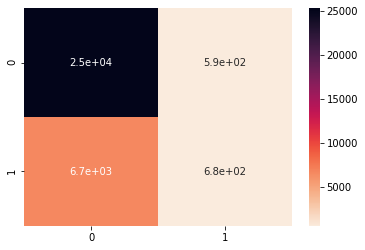

<matplotlib.axes._subplots.AxesSubplot at 0x7f724a1602d0>

In [0]:
#import sklearn
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
#print(classification_report(labels.collect(), predictions.collect()))
sn.heatmap(pd.DataFrame(confusion_matrix(l, p), index = [0,1], columns= [0,1]), annot=True, cmap=sns.cm.rocket_r)

In [0]:
print(classification_report(l,p))

precision recall f1-score support

 0.0 0.79 0.98 0.87 25896
 1.0 0.54 0.09 0.16 7391

 accuracy 0.78 33287
 macro avg 0.66 0.53 0.52 33287
weighted avg 0.73 0.78 0.72 33287

### Random Forest

In [0]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.tree import RandomForest
from pyspark.ml import Pipeline
from time import *
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.feature import StringIndexer, VectorAssembler
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
final_6m1 = spark.read.option("header", "true").parquet(f"dbfs:/tmp/out/final_6m1.parquet")
display(final_6m1.take(10))

MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DEL15,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,LATE_AIRCRAFT_DELAY,LATITUDE,LONGITUDE,WND_SPD,VIS_DIST,TMP_TEMP,DEW_TEMP,SLP_PRESSURE,PRECIPITATION,SNOW,CLOUD_COVERAGE,ALTIMETER_SET
1,4,UA,ORD,EWR,1200,0.0,1200-1259,25.0,1225,1448,13.0,1514,134.0,719.0,0.0,41.995,-87.9336,67,16093,-94,-150,10190,0,0,0,10179
1,4,MQ,ORD,AZO,1215,0.0,1200-1259,10.0,1219,1341,7.0,1403,48.0,122.0,0.0,41.995,-87.9336,67,16093,-94,-150,10190,0,0,0,10179
1,4,UA,ORD,PDX,1206,0.0,1200-1259,13.0,1227,1426,4.0,1445,279.0,1739.0,0.0,41.995,-87.9336,67,16093,-94,-150,10190,0,0,0,10179
1,4,MQ,ORD,DTW,1245,0.0,1200-1259,15.0,1302,1448,9.0,1458,73.0,235.0,0.0,41.995,-87.9336,67,16093,-94,-150,10190,0,0,0,10179
1,4,EV,ORD,MEM,1254,0.0,1200-1259,13.0,1301,1430,8.0,1447,113.0,491.0,0.0,41.995,-87.9336,67,16093,-94,-150,10190,0,0,0,10179
1,4,MQ,ORD,DTW,1140,1.0,1100-1159,14.0,1211,1354,8.0,1353,73.0,235.0,0.0,41.995,-87.9336,67,16093,-94,-150,10190,0,0,0,10179
1,4,AA,ORD,PHX,1205,1.0,1200-1259,15.0,1245,1510,7.0,1500,235.0,1440.0,0.0,41.995,-87.9336,67,16093,-94,-150,10190,0,0,0,10179
1,4,AA,ORD,DFW,1220,0.0,1200-1259,13.0,1236,1451,23.0,1455,155.0,802.0,0.0,41.995,-87.9336,67,16093,-94,-150,10190,0,0,0,10179
1,4,MQ,ORD,TYS,1230,0.0,1200-1259,14.0,1235,1436,22.0,1458,88.0,475.0,0.0,41.995,-87.9336,67,16093,-94,-150,10190,0,0,0,10179
1,4,EV,ORD,JAN,1155,0.0,1100-1159,10.0,1211,1404,4.0,1403,128.0,677.0,0.0,41.995,-87.9336,67,16093,-94,-150,10190,0,0,0,10179


In [0]:
final = final_6m1.select(final_6m1.columns[:6]+final_6m1.columns[7:]+final_6m1.columns[6:7])
final.columns

Out[36]: ['MONTH',
 'DAY_OF_WEEK',
 'OP_CARRIER',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'DEP_TIME_BLK',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'CRS_ELAPSED_TIME',
 'DISTANCE',
 'LATE_AIRCRAFT_DELAY',
 'LATITUDE',
 'LONGITUDE',
 'WND_SPD',
 'VIS_DIST',
 'TMP_TEMP',
 'DEW_TEMP',
 'SLP_PRESSURE',
 'PRECIPITATION',
 'SNOW',
 'CLOUD_COVERAGE',
 'ALTIMETER_SET',
 'DEP_DEL15']

In [0]:
indexer = StringIndexer(inputCols=["OP_CARRIER", "ORIGIN", "DEST"], outputCols=["carrierIndex","originIndex","destIndex"])
indexed = indexer.fit(final).transform(final)
indexed = indexed.select(indexed.columns[:2]+indexed.columns[5:6]+indexed.columns[7:-4]+indexed.columns[-3:]+indexed.columns[-4:-3])
indexed.columns

Out[55]: ['MONTH',
 'DAY_OF_WEEK',
 'CRS_DEP_TIME',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'CRS_ELAPSED_TIME',
 'DISTANCE',
 'LATE_AIRCRAFT_DELAY',
 'LATITUDE',
 'LONGITUDE',
 'WND_SPD',
 'VIS_DIST',
 'TMP_TEMP',
 'DEW_TEMP',
 'SLP_PRESSURE',
 'PRECIPITATION',
 'SNOW',
 'CLOUD_COVERAGE',
 'ALTIMETER_SET',
 'carrierIndex',
 'originIndex',
 'destIndex',
 'DEP_DEL15']

In [0]:
TRAINING_DATA_RATIO = 0.85
RANDOM_SEED = 123
transformed_df = indexed.rdd.map(lambda row: LabeledPoint(row[-1], Vectors.dense(row[0:-1])))

splits = [TRAINING_DATA_RATIO, 1.0 - TRAINING_DATA_RATIO]
training_data, test_data = transformed_df.randomSplit(splits, RANDOM_SEED)

print("Number of training set rows: %d" % training_data.count())
print("Number of test set rows: %d" % test_data.count())


Number of training set rows: 272750
Number of test set rows: 48118

In [0]:
start_time = time()

RF_NUM_TREES = 20
RF_MAX_DEPTH = 10
RF_MAX_BINS = 20

model = RandomForest.trainClassifier(training_data, numClasses=2, categoricalFeaturesInfo={}, \
    numTrees=RF_NUM_TREES, featureSubsetStrategy="auto", impurity="gini", \
    maxDepth=RF_MAX_DEPTH, maxBins=RF_MAX_BINS, seed=RANDOM_SEED)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

Time to train model: 10.551 seconds

In [0]:
predictions = model.predict(test_data.map(lambda x: x.features))
labels_and_predictions = test_data.map(lambda x: x.label).zip(predictions)
acc = labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(test_data.count())
print("Model accuracy: %.3f%%" % (acc * 100))

Model accuracy: 88.065%

In [0]:
start_time = time()

metrics = BinaryClassificationMetrics(labels_and_predictions)
print("Area under Precision/Recall (PR) curve: %.f" % (metrics.areaUnderPR * 100))
print("Area under Receiver Operating Characteristic (ROC) curve: %.3f" % (metrics.areaUnderROC * 100))

end_time = time()
elapsed_time = end_time - start_time
print("Time to evaluate model: %.3f seconds" % elapsed_time)

Area under Precision/Recall (PR) curve: 47
Area under Receiver Operating Characteristic (ROC) curve: 90.776
Time to evaluate model: 4.444 seconds